In [194]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np
from matplotlib import pyplot as plt
from pandas import DataFrame
from scipy.stats import mannwhitneyu
import statsmodels.api as sm

In [274]:
data = pd.read_csv("kickstarter_data.csv")
data['success_rate'] = data['pled'] / data['goal']
data.columns, data.shape

(Index(['Unnamed: 0', 'URL', 'pled', 'goal', 'date', 'period', 'status',
        'text_am', 'n_img', 'n_vid', 'n_pled_t', 'min_pled_t', 'max_pled_t',
        'mean_pled_t', 'step_pled_t', 'cr_time', 'backed', 'created', 'site',
        'rpg', 'platformer', 'shooter', 'fighting', 'survival', 'horror',
        'strategy', 'arcade', 'simulator', 'mmo', 'indie', 'action', 'quest',
        'adventure', 'mgp', 'cont', 'curr', 'succsess', 'is_site',
        'success_rate'],
       dtype='object'),
 (8421, 39))

In [196]:
data[data['goal'] < 5]['success_rate'].mean()

3315.4035573094015

<AxesSubplot:>

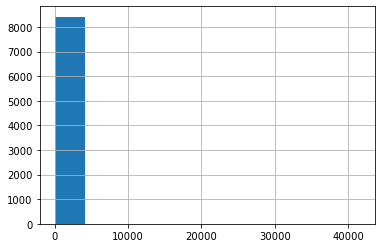

In [197]:
data['success_rate'].hist(bins=10)

In [198]:
df = data
if 'Unnamed: 0' in df.columns or 'succsess' in df.columns:
    df = data.drop(columns=['Unnamed: 0', 'succsess'])
df.shape

(8421, 37)

In [199]:
df.isnull().sum()

URL                0
pled               0
goal               0
date               0
period             0
status             0
text_am            0
n_img              0
n_vid              0
n_pled_t           0
min_pled_t         0
max_pled_t         0
mean_pled_t        0
step_pled_t        0
cr_time            0
backed             0
created            0
site            2471
rpg                0
platformer         0
shooter            0
fighting           0
survival           0
horror             0
strategy           0
arcade             0
simulator          0
mmo                0
indie              0
action             0
quest              0
adventure          0
mgp                0
cont               0
curr               0
is_site            0
success_rate       0
dtype: int64

In [200]:
numeric_columns = ['pled',
  'goal',
  'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
  'min_pled_t',
  'max_pled_t',
  'mean_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont']
binary_columns = ['rpg',
  'platformer',
  'shooter',
  'fighting',
  'survival',
  'horror',
  'strategy',
  'arcade',
  'simulator',
  'mmo',
  'indie',
  'action',
  'quest',
  'adventure',
  'is_site']
futures = ['text_am', 'n_img', 'n_vid', 'created', 'cont', 'mgp', 'n_pled_t']
target_column = 'success_rate'
numeric_columns, target_column

(['pled',
  'goal',
  'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
  'min_pled_t',
  'max_pled_t',
  'mean_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont'],
 'success_rate')

In [201]:
def draw_boxplots(df, numeric_columns):
    fig, axes = plt.subplots(4, 4, figsize=(18, 40))
    for i in range(2):
        for j in range(4):
            if 4 * i + j == len(numeric_columns):
                return
            axes[i, j].boxplot(df[numeric_columns[4 * i + j]], labels=[numeric_columns[4 * i + j]]) 

In [202]:
def draw_hist(df, features, bar_type=None, n_bins=10):
    bar_type = 'bar' if bar_type == None else bar_type
    rows = 2
    cols = 4
    plt.subplots_adjust(wspace=0.6, hspace=0.3)
    fig, axes = plt.subplots(rows, cols, figsize=(36, 18))
    for i in range(rows):
        for j in range(cols):
            if cols * i + j == len(features):
                return
            
            axes[i, j].hist(df[features[4 * i + j]], histtype=bar_type, bins=n_bins)
            axes[i, j].set_xlabel(f'Значение переменной {features[4 * i + j]}', size=14)
            axes[i, j].set_ylabel(f'Количество проектов с таким {features[4 * i + j]}', size=14)

In [287]:
def del_n_sigmas_emissions(df, col_name, n_sigmas=3) -> DataFrame:
    std = df[col_name].std()
    mean = df[col_name].mean()
    return df[(df[col_name] >= mean - std * n_sigmas) & (df[col_name] <= mean + std * n_sigmas)]

In [288]:
# Remove emissions
df = data[:]
df['site'].fillna('', inplace=True)

# Using 3 sigmas rule
df = del_n_sigmas_emissions(df, 'created')
df = del_n_sigmas_emissions(df, 'n_pled_t')
df = del_n_sigmas_emissions(df, 'goal') # Probably remove < 5.0 projects too
df = del_n_sigmas_emissions(df, 'period')
df = del_n_sigmas_emissions(df, 'success_rate')

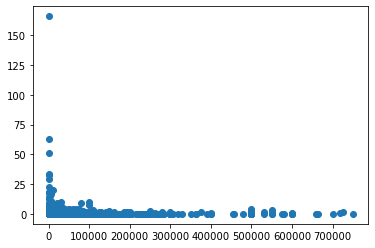

In [289]:
plt.scatter(df['goal'][:df.shape[0] // 4], df['success_rate'][:df.shape[0] // 4])

((8038, 39),
 count      8038.000000
 mean      39262.285126
 std       84992.094560
 min           1.000000
 25%        3500.000000
 50%       10000.000000
 75%       35000.000000
 max      775803.910000
 Name: goal, dtype: float64)

<Figure size 432x288 with 0 Axes>

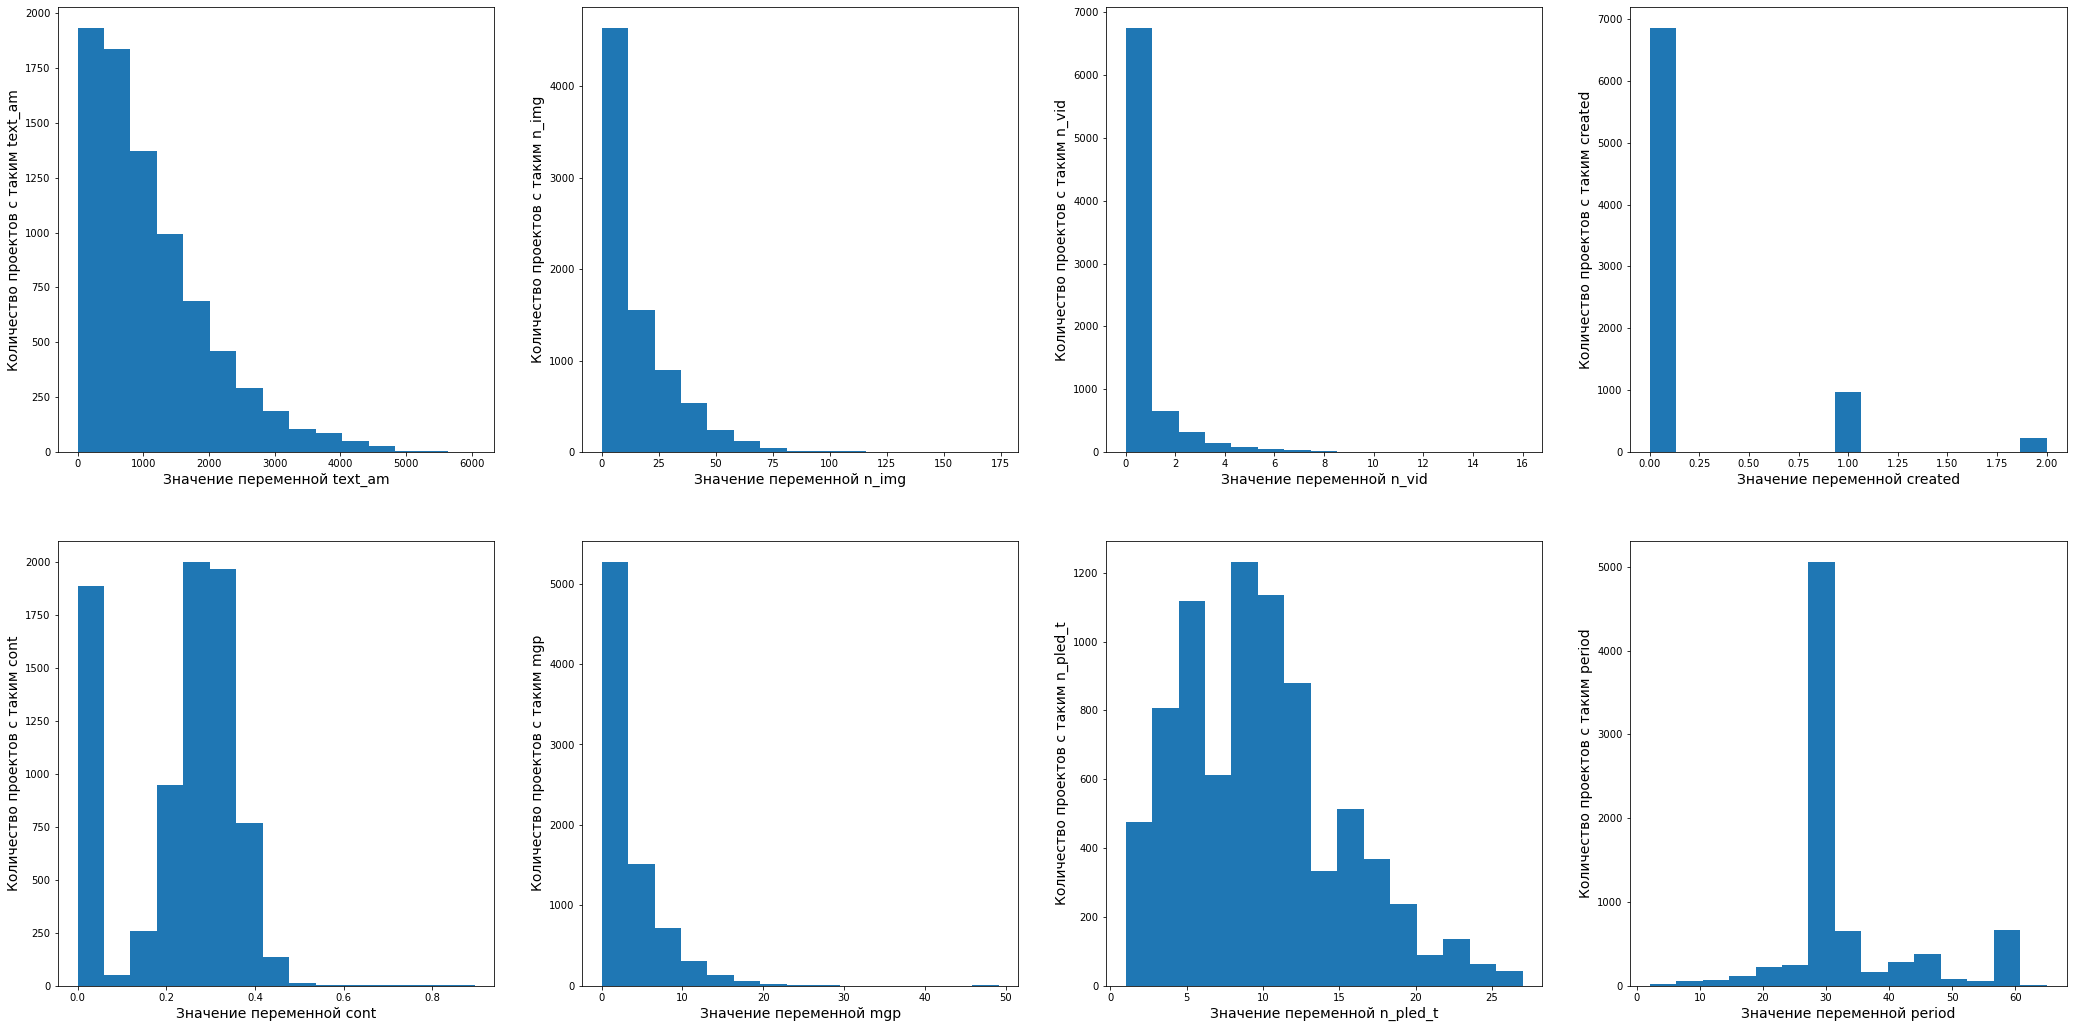

In [285]:
draw_hist(df, futures + ['period'], n_bins=15)
df.shape, df['goal'].describe()

In [206]:
# Descriptive statistics
desc = df[futures].describe()
desc.loc[:'count'] = desc.loc[:'count'].astype(np.int64)
desc.append(pd.Series(df[futures].median(), index=futures, name='median'))
desc

,text_am,n_img,n_vid,created,cont,mgp,n_pled_t
count,8032.000000,8032.000000,8032.000000,8032.000000,8032.000000,8032.000000,8032.000000
mean,1116.695344,14.050050,0.729084,0.174925,0.224092,3.123479,9.768302
std,901.939501,16.288765,1.294052,0.445404,0.137803,3.897499,5.281301
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,417.750000,1.000000,0.000000,0.000000,0.147121,0.226729,6.000000
50%,873.000000,8.000000,0.000000,0.000000,0.268400,1.734000,9.000000
75%,1569.250000,22.000000,1.000000,0.000000,0.321965,4.566584,13.000000
max,6042.000000,174.000000,16.000000,2.000000,0.894847,49.141376,27.000000


In [143]:
pd.DataFrame(df.corr()['success_rate'][futures])

,success_rate
text_am,0.022853
n_img,0.035806
n_vid,0.052602
created,0.021287
cont,0.030704
mgp,0.043453
n_pled_t,0.013151


In [149]:
def draw_dependencies(df, features):
    rows = 2
    cols = 4
    plt.subplots_adjust(wspace=0.6, hspace=0.3)
    fig, axes = plt.subplots(rows, cols, figsize=(36, 18))
    for i in range(rows):
        for j in range(cols):
            if cols * i + j == len(features):
                return
            
            col = features[cols * i + j]
            xs = []
            ys = []

            if col == 'text_am':
                n_texts = []
                step = 200
                for v in range(1, df['text_am'].max(), step):
                    s = df[(df['text_am'] >= v) & (df['text_am'] < v + step)]['success_rate']
                    if s.shape[0] > 5: 
                        n_texts.append((f'{int((2 * v + step) / 2)}', v, s.sum() / s.shape[0]))

                n_texts = sorted(n_texts, key=lambda x: x[1])

                xs = [k for title, k, v in n_texts]
                ys = [v for title, k, v in n_texts]
            elif col == 'cont':
                n_conts = []
                step = 0.05
                for v in np.arange(0, df['cont'].max(), step):
                    s = df[(df['cont'] >= v) & (df['cont'] < v + step)]['cont']
                    if s.shape[0] > 2: 
                        n_conts.append((f'{(2 * v + step) / 2}', v, s.sum() / s.shape[0]))

                n_conts = sorted(n_conts, key=lambda x: x[1])

                xs = [k for title, k, v in n_conts]
                ys = [v for title, k, v in n_conts]
            else:
                for val in sorted(df[col].unique()):
                    mean_sr = df[df[col] == val]['success_rate'].mean()
                    if df[df[col] == val].shape[0] > 5:
                        xs.append(val)
                        ys.append(mean_sr)

            axes[i, j].plot(xs, ys)
            axes[i, j].set_xlabel(f'Значение переменной {features[4 * i + j]}', size=14)
            axes[i, j].set_ylabel(f'Значение переменной success_rate', size=14)

In [260]:
def split_array_by_parts(array_len, n_splits):
    """
    Returns indices for split parts
    """
    step = 0
    if array_len % n_splits == 0:
        step = array_len // n_splits
    else:
        step = array_len // n_splits + 1
    i = 0
    result = []
    while i < array_len:
        result.append((i, min(i + step, array_len)))
        i += step
    return result


def draw_dep(df, cols, n_intervals):
    step = 1.0 / n_intervals
    
    n_rows = 2
    n_cols = 4
    plt.subplots_adjust(wspace=0.6, hspace=0.3)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(36, 18), sharey=False)
    
    indices = split_array_by_parts(df.shape[0], n_intervals)
    
    for i in range(n_rows):
        for j in range(n_cols):
            if n_cols * i + j == len(cols):
                return
            
            col = cols[n_cols * i + j]
            plot_vals = {}
            repeats = {}
            xs = []
            ys = []
            
            sorted_df = df.sort_values(by=[col])
            for start, stop in indices:
                cur_vals = sorted_df.iloc[start : stop]
                col_median = cur_vals[col].median()
                s_r_mean = cur_vals['success_rate'].mean()
                
                xs.append(col_mean)
                ys.append(s_r_mean)
            if col == 'text_am':
                print(xs)
            new_xs, new_ys = [], []
            reps = {}
            vals = {}
            for x, y in zip(xs, ys):
                if x not in reps:
                    reps[x] = 0
                    vals[x] = []
                reps[x] += 1
                vals[x].append(y)
            for x, n_reps in reps.items():
                new_ys.append(sum(vals[x]) / n_reps)
                es = 0
                if col == 'text_am':
                    x /= 100
                new_xs.append(float(f'{x:.2f}'))
                
                
            axes[i, j].bar(new_xs, new_ys)
            if col == 'text_am':
                axes[i, j].set_xlabel(f'Среднее значение {col}, в сотнях.')
            else:
                axes[i, j].set_xlabel(f'Среднее значение {col}')
            axes[i, j].set_ylabel(f'Среднее значение success_rate')            

[103.5, 182.0, 248.0, 314.0, 384.0, 459.0, 548.0, 631.5, 726.0, 819.5, 932.0, 1051.0, 1171.0, 1320.0, 1482.5, 1665.0, 1889.0, 2178.0, 2601.5, 3538.5]


<Figure size 432x288 with 0 Axes>

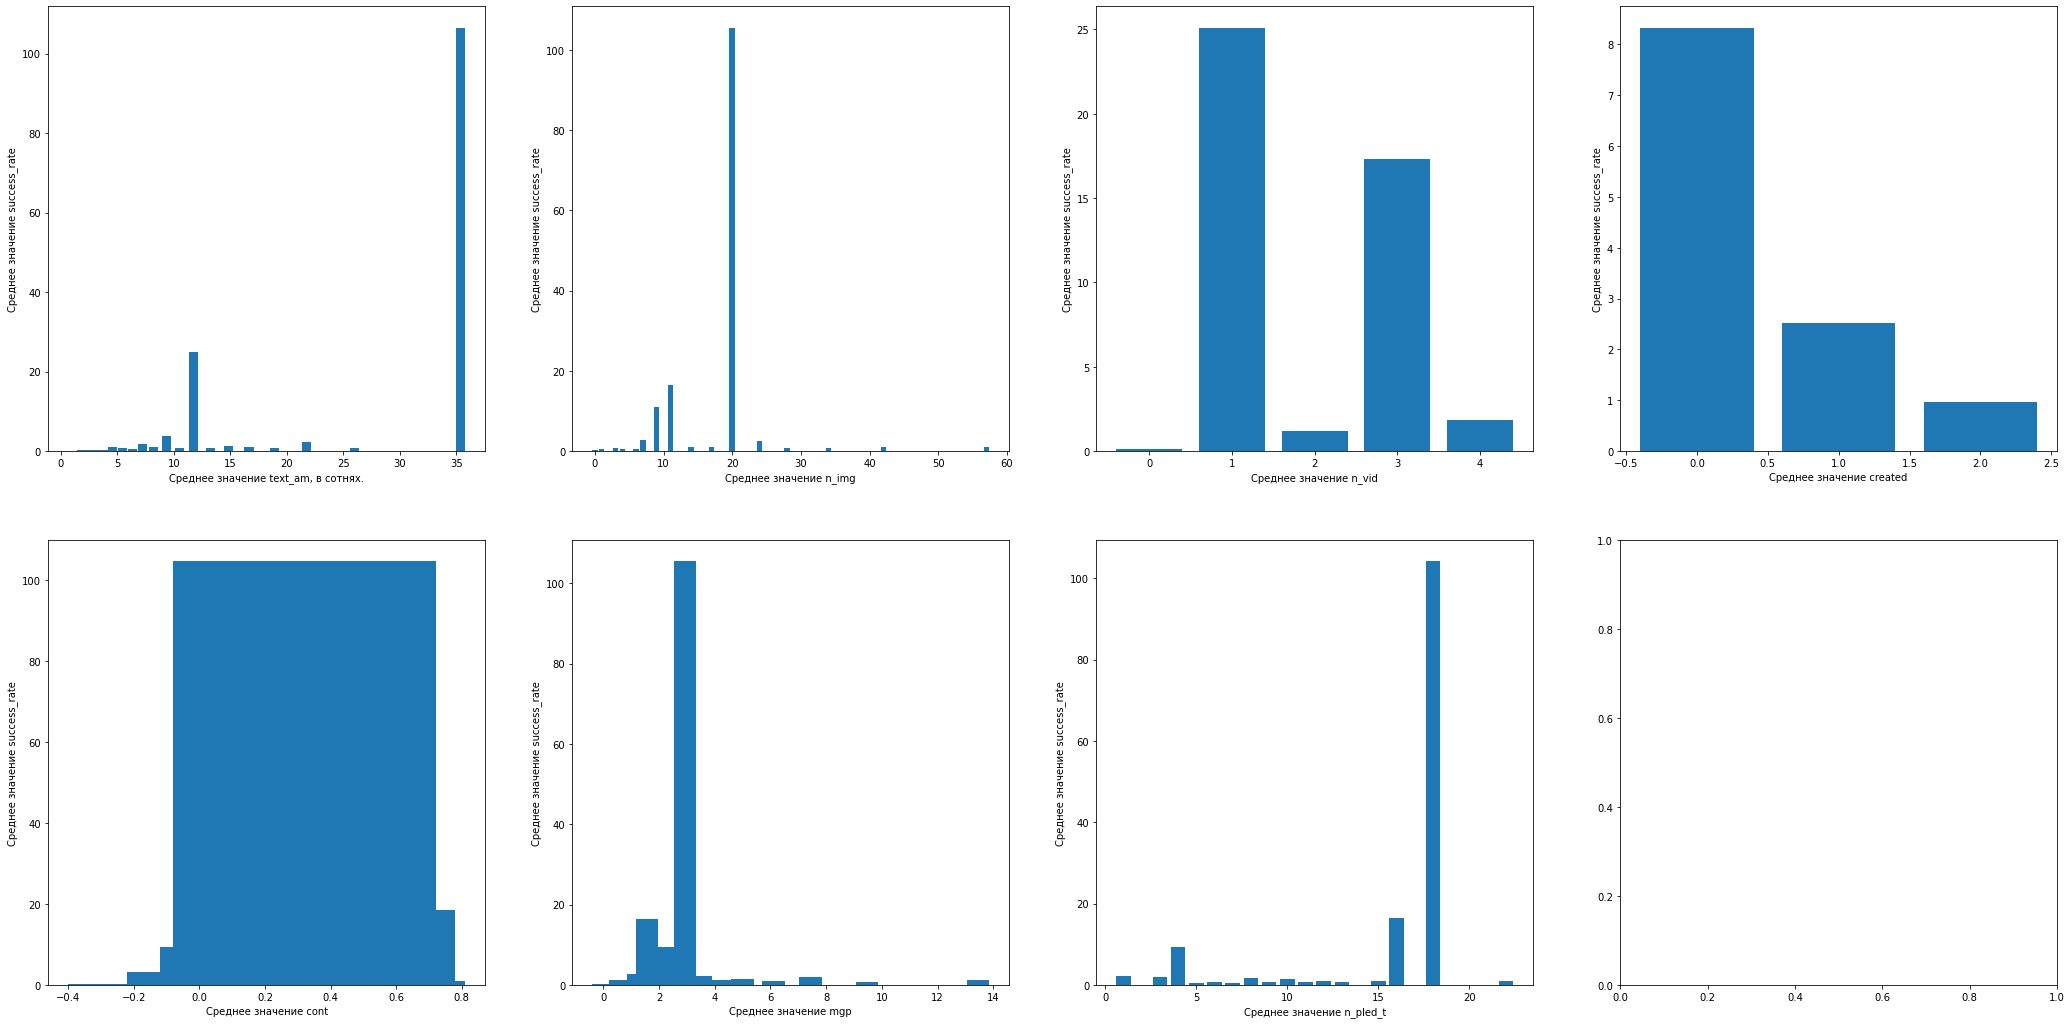

In [265]:
# draw_dependencies(df, futures)
draw_dep(df, futures, 20)

In [126]:
for col, val in zip(futures, [800, 20, 1, None, None, 0.6, 3]):
    print(col, val)
    if val == None:
        continue
    # plt.figure(figsize=(10,8))
    x = df[df[col] <= val][col]
    y = df[df[col] > val][col]

    # x.hist()
    # y.hist()

    u1, p = mannwhitneyu(x, y, alternative='less', use_continuity=False)
    print(col, 1.0 - p, u1)

text_am 800
text_am 1.0 0.0
n_img 20
n_img 1.0 0.0
n_vid 1
n_vid 1.0 0.0
created None
cont None
mgp 0.6
mgp 1.0 0.0
n_pled_t 3
n_pled_t 1.0 0.0


In [184]:
# Linear models
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np

In [257]:
numeric_columns = [
#   'pled',
  'goal',
#   'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
  'min_pled_t',
  'max_pled_t',
  'mean_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont']
binary_columns = ['rpg',
  'platformer',
  'shooter',
  'fighting',
  'survival',
  'horror',
  'strategy',
  'arcade',
  'simulator',
  'mmo',
  'indie',
  'action',
  'quest',
  'adventure',
  'is_site']
columns = numeric_columns + binary_columns

In [258]:
def test_mse(model, X, y):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    
    return mse

In [259]:
train_X, test_X, train_y, test_y = train_test_split(df[columns], df[target_column], train_size=0.8, random_state=42)

In [260]:
scaler = StandardScaler()

train_data = scaler.fit_transform(train_X)
test_x_data = scaler.transform(test_X)
test_y_data = test_y

In [261]:
# Simple Linear Regression
model = LinearRegression()
model.fit(train_data, train_y)

test_mse(model, train_data, train_y), test_mse(model, test_x_data, test_y_data), model.coef_

(369387.3383647816,
 1869795.3672192502,
 array([ -5.29562201,  -3.94568917, -36.78462488,  30.70267808,
         -6.71222584,   6.63198769,  -2.97476433, -18.91831774,
         10.94099963,  19.45646239,   0.12686905,   8.85645781,
         51.69608167,   7.787957  ,  22.56079169,  24.9127564 ,
         -2.02776832,  -9.39889504, -10.00238474,  20.95372327,
         -4.28502789,   4.56782208,  12.82337491,  -3.78337242,
          1.22605663,  -9.2937159 ,  17.81108513,   7.39411438,
         14.05166685]))

In [262]:
# Testing regression /w L1 regularization
lasso = Lasso()
lasso.fit(train_data, train_y)

test_mse(lasso, train_data, train_y), test_mse(lasso, test_x_data, test_y_data), lasso.coef_

(369443.92623687984,
 1869396.3096983938,
 array([ -4.84337819,  -3.21568635, -28.23602214,  29.7994403 ,
         -6.44776695,   2.52182324,  -4.26765883,  -9.22126826,
          3.20104038,  19.0840099 ,   0.        ,   8.38331093,
         43.60456515,   6.44651965,  21.08137386,  24.01334221,
         -1.26366076,  -8.78353439,  -9.1286698 ,  19.69955156,
         -3.81846818,   3.03408799,  11.68386857,  -3.12711678,
          0.        ,  -8.47665314,  16.68048407,   6.3905155 ,
         12.75825447]))

In [263]:
# Testing regression /w L2 regularization
ridge = Ridge()
ridge.fit(train_data, train_y)

test_mse(ridge, train_data, train_y), test_mse(ridge, test_x_data, test_y_data), ridge.coef_

(369387.33934873244,
 1869793.168207298,
 array([ -5.29530015,  -3.94989799, -36.72692248,  30.69897246,
         -6.71033224,   6.62041163,  -2.98958042, -18.88373971,
         10.92351691,  19.45423654,   0.1273822 ,   8.85665654,
         51.64294124,   7.7867679 ,  22.55622567,  24.90759275,
         -2.02830407,  -9.39804398, -10.00097394,  20.95014801,
         -4.28480458,   4.56539151,  12.82133472,  -3.78239093,
          1.2248406 ,  -9.29275838,  17.8082882 ,   7.39241105,
         14.04927472]))

In [264]:
elastic = ElasticNet()
elastic.fit(train_data, train_y)

test_mse(elastic, train_data, train_y), test_mse(elastic, test_x_data, test_y_data), elastic.coef_

(370274.82153643493,
 1869050.0547052594,
 array([-3.89452421, -1.20312137, -1.09005786, 20.31277309, -1.89791419,
         0.78070555, -3.99608652, -4.72951478,  0.        , 13.66106424,
         1.73976422,  7.78048434, 15.18854159,  5.84617869, 13.69151719,
        15.76857933, -2.11677263, -5.95061866, -6.01373644, 13.12450412,
        -3.72472531,  1.3119343 ,  7.98886789, -2.49808485,  1.18778916,
        -5.46233285, 11.95225738,  5.69347621,  8.89973488]))

In [265]:
regr = sm.OLS(df['success_rate'], df[columns])
res = regr.fit()

results_as_html = res.summary().tables[1].as_html()
summary_df = pd.read_html(results_as_html, header=0, index_col=0)[0]

In [266]:
# Get mean coeffs for futures
coeffs = np.zeros((len(columns)))
rounds = 20
for i in range(20):
    inp = df[columns]
    train_y = df[target_column]
    scaler = StandardScaler()

    train_data = scaler.fit_transform(inp)
    
    model = LinearRegression()
    model.fit(train_data, train_y)
    coeffs += model.coef_
    
    lasso = Lasso()
    lasso.fit(train_data, train_y)
    coeffs += lasso.coef_
    
    ridge = Ridge()
    ridge.fit(train_data, train_y)
    coeffs += ridge.coef_
    
    elastic = ElasticNet()
    elastic.fit(train_data, train_y)
    coeffs += elastic.coef_
    
mean_coeffs = coeffs / (rounds * 4)
coeffs = [(k, v) for k, v in zip(columns, mean_coeffs)]
coeffs.sort(key=lambda x: abs(x[1]), reverse=True)
for k, v in coeffs:
  print(f'{k}: {v:.3f}')

cr_time: 35.358
mgp: 32.056
n_vid: 30.075
n_pled_t: -16.230
rpg: 16.057
is_site: 15.855
platformer: 15.791
mean_pled_t: -13.603
horror: 12.851
quest: 10.345
n_img: -9.835
action: -9.730
survival: -9.521
fighting: -8.190
cont: 8.039
strategy: -7.311
simulator: 7.005
goal: -5.155
mmo: -3.748
min_pled_t: 3.678
shooter: -3.613
backed: -3.362
step_pled_t: 2.164
max_pled_t: -1.947
adventure: 1.530
indie: -1.479
text_am: -1.332
created: 0.987
arcade: 0.057


In [267]:
# Neural network
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [53]:
def get_type(rate):
    type_ = 0
    for i in np.linspace(0, 175, 8):
        if rate < i + 25:
            return type_
        type_ += 1
    return 8

In [54]:
# Add success type

types = []

for idx, row in df.iterrows():
    types.append(get_type(row[-1]))

types = pd.Series(types, dtype=int)
df = df.assign(succes_type=types.values)
print(df[['success_rate', 'succes_type']].head(20))
if 'success_rate' in df.columns:
    df = df.drop(columns='success_rate')
if 'success' in df.columns:
    df = df.drop(columns='success')

    success_rate  succes_type
0       0.100012            0
1    1714.220076            8
2       3.460000            0
3       0.010000            0
4       8.082090            0
5     254.160000            8
6     104.620000            4
7      11.800000            0
8       8.257500            0
9       0.020000            0
10      1.101250            0
11      0.000000            0
12     22.448000            0
13      3.400000            0
14      0.157083            0
15    100.200000            4
16    132.800022            5
17      1.236000            0
18      0.950000            0
19    229.933333            8


In [55]:
df.columns

Index(['Unnamed: 0', 'URL', 'pled', 'goal', 'date', 'period', 'status',
       'text_am', 'n_img', 'n_vid', 'n_pled_t', 'min_pled_t', 'max_pled_t',
       'mean_pled_t', 'step_pled_t', 'cr_time', 'backed', 'created', 'site',
       'rpg', 'platformer', 'shooter', 'fighting', 'survival', 'horror',
       'strategy', 'arcade', 'simulator', 'mmo', 'indie', 'action', 'quest',
       'adventure', 'mgp', 'cont', 'curr', 'succsess', 'is_site',
       'succes_type'],
      dtype='object')

In [56]:
numeric_columns = [
#   'pled',
  'goal',
#   'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
  'min_pled_t',
  'max_pled_t',
  'mean_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont']
binary_columns = ['rpg',
  'platformer',
  'shooter',
  'fighting',
  'survival',
  'horror',
  'strategy',
  'arcade',
  'simulator',
  'mmo',
  'indie',
  'action',
  'quest',
  'adventure',
  'is_site']

numeric_data = numeric_columns + binary_columns
target_col = df.corr().columns[-1]

print(numeric_data, target_col)

dataset = df[numeric_data]
target = df[target_col]

['goal', 'text_am', 'n_img', 'n_vid', 'n_pled_t', 'min_pled_t', 'max_pled_t', 'mean_pled_t', 'step_pled_t', 'cr_time', 'backed', 'created', 'mgp', 'cont', 'rpg', 'platformer', 'shooter', 'fighting', 'survival', 'horror', 'strategy', 'arcade', 'simulator', 'mmo', 'indie', 'action', 'quest', 'adventure', 'is_site'] succes_type


In [57]:
model = nn.Sequential(
    nn.BatchNorm1d(28),
    nn.Linear(28, 24),
    nn.ReLU(),
    nn.BatchNorm1d(24),
    nn.Linear(24, 20),
    nn.ReLU(),
    nn.BatchNorm1d(20),
    nn.Linear(20, 10))

optimizer = Adam(model.parameters())
loss_fn = F.cross_entropy

In [58]:
class MyDataset:
    def __init__(self, df):
        self.df = pd.DataFrame(data=df)
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, i):
        return torch.Tensor(self.df.iloc[i])[:-1], torch.Tensor(self.df.iloc[i])[-1].to(torch.long)

In [59]:
from torch.utils.data import DataLoader


train, test = train_test_split(dataset, train_size=0.8)

train_loader = DataLoader(MyDataset(train), batch_size=24, shuffle=True)
test_loader = DataLoader(MyDataset(test), batch_size=24)

In [65]:
model.train()

losses = []
accuracies = []

for epochs in tqdm(range(20)):
    epoch_losses = []
    epoch_accuracies = []
    for xb, yb in tqdm(train_loader):
        accuracy = 0
        correct_answers = 0
        
        optimizer.zero_grad()

        outp = model(xb)
        loss = loss_fn(outp, yb)

        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
        
        correct_answers = (outp.argmax(-1) == yb).sum()
        accuracy = correct_answers / xb.shape[0]
        epoch_accuracies.append(accuracy)
    
    losses.append(torch.tensor(epoch_losses).mean())
    accuracies.append(torch.tensor(epoch_accuracies).mean())
    
    print('loss:', losses[-1])
    print('accuracy: ', accuracies[-1])

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5084)
accuracy:  tensor(0.7386)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5082)
accuracy:  tensor(0.7455)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5060)
accuracy:  tensor(0.7474)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5052)
accuracy:  tensor(0.7438)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5016)
accuracy:  tensor(0.7485)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5061)
accuracy:  tensor(0.7511)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.4982)
accuracy:  tensor(0.7534)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.4990)
accuracy:  tensor(0.7506)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.4967)
accuracy:  tensor(0.7520)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.4988)
accuracy:  tensor(0.7525)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.4961)
accuracy:  tensor(0.7531)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5006)
accuracy:  tensor(0.7563)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.4945)
accuracy:  tensor(0.7540)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.4894)
accuracy:  tensor(0.7586)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.4933)
accuracy:  tensor(0.7555)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.4908)
accuracy:  tensor(0.7594)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.4984)
accuracy:  tensor(0.7517)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.4938)
accuracy:  tensor(0.7537)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.4912)
accuracy:  tensor(0.7555)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.4932)
accuracy:  tensor(0.7508)


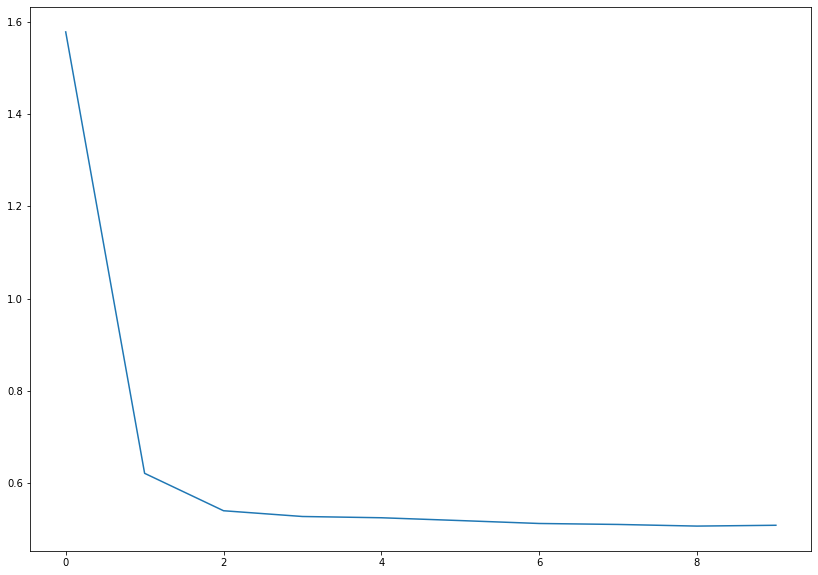

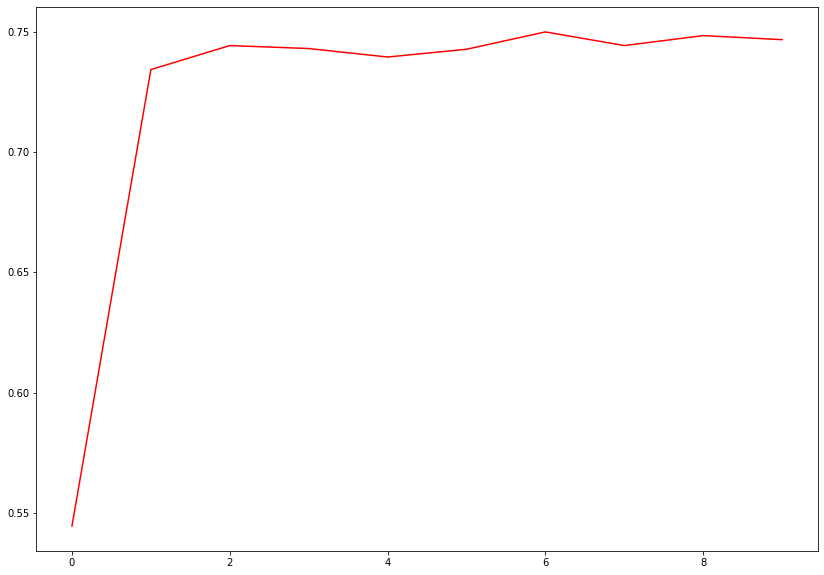

In [61]:
plt.figure(figsize=(14, 10))
plt.plot(range(epochs + 1), losses, label='loss')

plt.figure(figsize=(14, 10))
plt.plot(range(epochs + 1), accuracies, label='accuracy', c='r')

In [113]:
model.eval()

preds = []
real = []

losses = []
accuracies = []

for xb, yb in test_loader:
    with torch.no_grad():
        outp = model(xb)
        for val in outp.argmax(-1):
            preds.append(val.item())
        for val in yb:
            real.append(val.item())
        
        correct_answers = (outp.argmax(-1) == yb).sum()
        accuracy = correct_answers / xb.shape[0]
        accuracies.append(accuracy)

torch.Tensor(accuracies).mean(), torch.Tensor(accuracies).median()

(tensor(0.7443), tensor(0.7500))

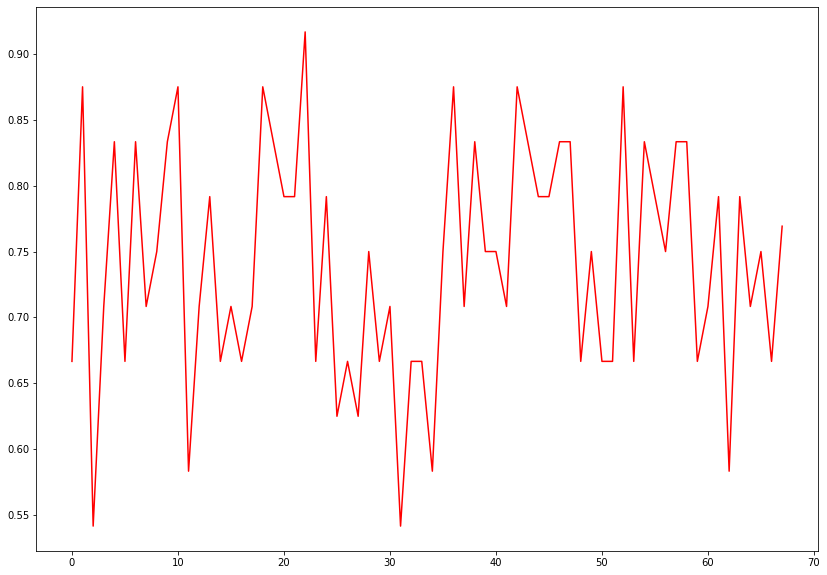

In [63]:
plt.figure(figsize=(14, 10))
plt.plot(np.arange(len(test_loader)), accuracies, label='accuracy', c='r')

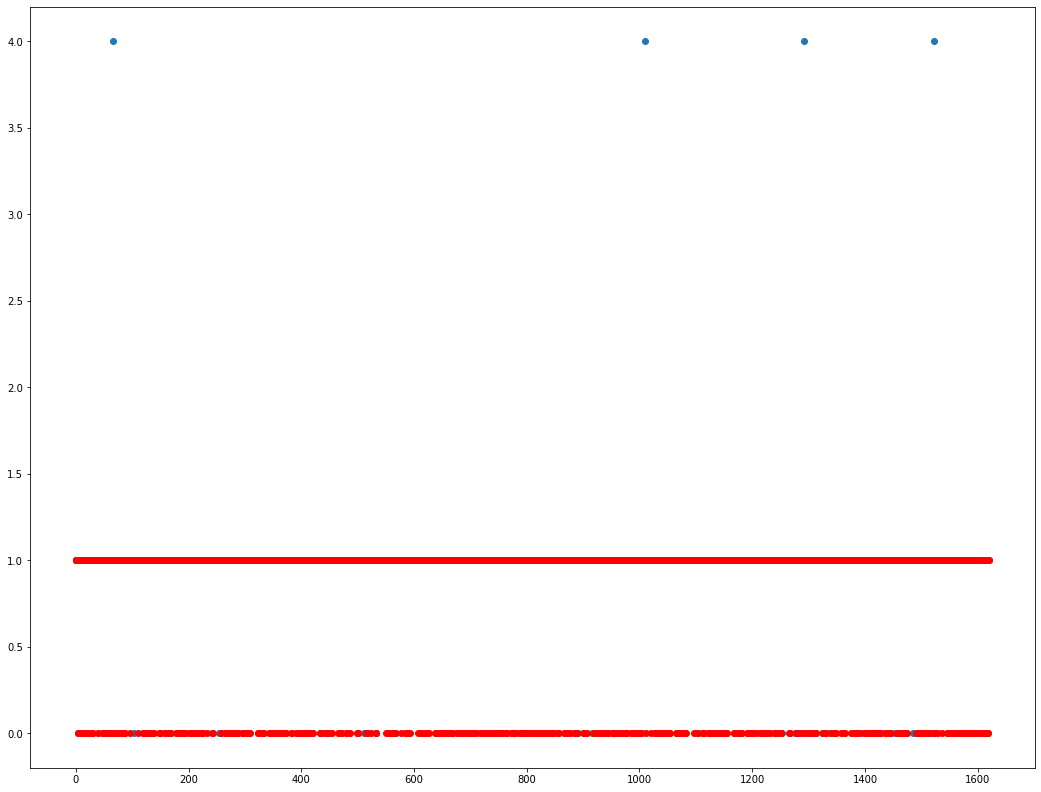

In [64]:
plt.figure(figsize=(18, 14))
plt.scatter(np.arange(len(preds)), preds)
plt.scatter(np.arange(len(real)), real, c='red')